
# Análise exploratória ~ ENEM 2020 


In [ ]:
#instalando pacotes
!pip install pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#iniciando sessão
spark = SparkSession.builder.appName("DadosEnem2020").getOrCreate()

In [ ]:
#lendo o dataset
df_pyspark = spark.read.csv('/content/drive/MyDrive/DESAFIO ENEM 2020/MICRODADOS_ENEM_2020.csv',header = True,sep = ';',inferSchema = True)
df_pyspark.show()

In [ ]:
#dimensão do dataset
print((df_pyspark.count(), len(df_pyspark.columns)))

In [ ]:
df_pyspark.columns

In [ ]:
df_pyspark.dtypes

In [ ]:
#valores nulos para cada coluna
from pyspark.sql.functions import when, count, col
df_pyspark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_pyspark.columns]).show(vertical=True)

In [8]:
# as colunas 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC' e 'SG_UF_ESC' (dados da escola em que o inscrito estudou) 
# terão seus Null values preenchidos com os valores relativos ao local de aplicação da prova ('CO_MUNICIPIO_PROVA',...) 
from pyspark.sql.functions import coalesce
df1 = df_pyspark.withColumn('CO_MUNICIPIO_ESC', coalesce('CO_MUNICIPIO_ESC','CO_MUNICIPIO_PROVA'))
df2 = df1.withColumn('NO_MUNICIPIO_ESC', coalesce('NO_MUNICIPIO_ESC','NO_MUNICIPIO_PROVA'))
df3 = df2.withColumn('CO_UF_ESC', coalesce('CO_UF_ESC','CO_UF_PROVA'))
df_final = df3.withColumn('SG_UF_ESC', coalesce('SG_UF_ESC','SG_UF_PROVA'))

In [ ]:
df_final.select([count(when(col(c).isNull(), c)).alias(c) for c in df_final.columns]).show(vertical=True)

In [10]:
#divisão das variáveis

#colunas relacionadas as escolas
lista_escolas = ['CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC','CO_UF_ESC','SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC']

#colunas relacionadas as notas dos inscritos
lista_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

#colunas relacionadas aos dados cadastrais do inscrito
lista_dados_cadastrais = ['NU_INSCRICAO','TP_FAIXA_ETARIA','TP_SEXO','TP_ESTADO_CIVIL','TP_COR_RACA','TP_NACIONALIDADE','TP_ST_CONCLUSAO','TP_ANO_CONCLUIU','TP_ESCOLA','TP_ENSINO','IN_TREINEIRO']

In [11]:
df_dados_escola = df_final.select(lista_escolas)
df_dados_notas = df_final.select(lista_notas)
df_dados_cadastrais = df_final.select(lista_dados_cadastrais)

In [ ]:
#lista do número de escolas em cada Munícipio
df_dados_escola_group=df_dados_escola.groupBy("NO_MUNICIPIO_ESC").agg(count("NO_MUNICIPIO_ESC"))
df_dados_escola_group.withColumnRenamed("count(NO_MUNICIPIO_ESC)","Número de Escolas que os inscritos fizeram ensino médio no Município").sort("Número de Escolas que os inscritos fizeram ensino médio no Município",ascending = False).show()

In [ ]:
df_dados_escola = df_dados_escola.withColumn('Dependência Administrativa',when(col('TP_DEPENDENCIA_ADM_ESC')== 1, 'Federal')
                     .when(col('TP_DEPENDENCIA_ADM_ESC')==2, 'Estadual')
                     .when(col('TP_DEPENDENCIA_ADM_ESC')==3, 'Municipal')
                     .when(col('TP_DEPENDENCIA_ADM_ESC')==4, 'Privada')
                     .otherwise('Desconhecida'))
df_dados_escola = df_dados_escola.drop('TP_DEPENDENCIA_ADM_ESC')
df_dados_escola.show()

In [ ]:
import pyspark.sql.functions as F
df_dados_escola.groupby('Dependência Administrativa').count().withColumnRenamed('count','Contagem').withColumn('Porcentagem',F.round((F.col('Contagem') / df_dados_escola.count()) * 100,2 )).sort('Porcentagem',ascending=False).show()

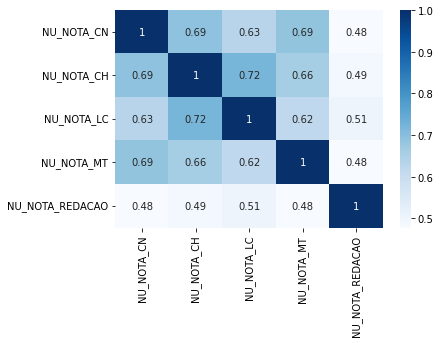

In [15]:
# Correlação entre as notas das provas do Enem
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
#excluindo alunos com notas zero
df_dados_notas = df_dados_notas.dropna(how='any')
# converter para vetor coluna 
vector_col = "corr_variaveis"
assembler = VectorAssembler(inputCols=df_dados_notas.columns, outputCol=vector_col)
df_vector = assembler.transform(df_dados_notas).select(vector_col)
# matriz correlação - mapa de calor
matrix= Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
fig= plt.subplots()
sns.heatmap(corrmatrix, annot=True, cmap = 'Blues',xticklabels=df_dados_notas.columns,yticklabels=df_dados_notas.columns);

Nota-se que existe uma correlação positiva forte entre as notas de LC (Linguagens e códigos), com de CH (Ciencias Humanas), ou seja quem vai bem em uma área, provavelmente também irá bem na outra.

In [ ]:
df_dados_cadastrais.show()

In [ ]:
df_dados_cadastrais.select([count(when(col(c).isNull(), c)).alias(c) for c in df_dados_cadastrais.columns]).show(vertical=True)

In [ ]:
#preenchendo valores nulos da coluna 'TP_ENSINO' com o valor 0 (desconhecido)
df_dados_cadastrais = df_dados_cadastrais.na.fill(value=0,subset = ['TP_ENSINO'])
df_dados_cadastrais.show()

In [19]:
#tratando as colunas

#estado civil
df_dados_cadastrais = df_dados_cadastrais.withColumn('Estado Civil',when(col('TP_ESTADO_CIVIL')== 0, 'Não Informado')
                     .when(col('TP_ESTADO_CIVIL')==1, 'Solteiro(a)')
                     .when(col('TP_ESTADO_CIVIL')==2, 'Casado/MoraComCompanheiro(a)')
                     .when(col('TP_ESTADO_CIVIL')==3, 'Divorciado(a)/Desquitado(a)/Separado(a)')
                     .when(col('TP_ESTADO_CIVIL')==4, 'Viúvo(a)'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_ESTADO_CIVIL')

In [20]:
#cor/raça
df_dados_cadastrais = df_dados_cadastrais.withColumn('Cor/Raça',when(col('TP_COR_RACA')== 0, 'Não Declarado')
                     .when(col('TP_COR_RACA')==1, 'Branca')
                     .when(col('TP_COR_RACA')==2, 'Preta')
                     .when(col('TP_COR_RACA')==3, 'Parda')
                     .when(col('TP_COR_RACA')==4, 'Amarela')
                     .when(col('TP_COR_RACA')==5, 'Indígena '))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_COR_RACA')

In [21]:
#faixa etaria
df_dados_cadastrais = df_dados_cadastrais.withColumn('Faixa Etaria',when(col('TP_FAIXA_ETARIA')== 1, 'Menor de 17 Anos')
                     .when(col('TP_FAIXA_ETARIA') < 12,'De 17 a 30 Anos')
                     .when(col('TP_FAIXA_ETARIA') < 18,'De 31 a 60 Anos')
                     .otherwise('Maior que 60 Anos'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_FAIXA_ETARIA')

In [22]:
#nacionalidade
df_dados_cadastrais = df_dados_cadastrais.withColumn('Nacionalidade',when(col('TP_NACIONALIDADE')== 0, 'Não Informado')
                     .when(col('TP_NACIONALIDADE') == 1,'Brasileiro(a)')
                     .when(col('TP_NACIONALIDADE') == 2,'Brasileiro(a) Naturalizado(a)')
                     .when(col('TP_NACIONALIDADE') == 3,'Estrangeiro(a)')
                     .otherwise('Brasileiro(a) Nato(a), nascido(a) no exterior'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_NACIONALIDADE')

In [23]:
#situacao ensino medio
df_dados_cadastrais = df_dados_cadastrais.withColumn('Situação Conclusão Ensino Médio',when(col('TP_ST_CONCLUSAO')== 1, 'Ensino Médio Concluído')
                     .when(col('TP_ST_CONCLUSAO') == 2,'Estou cursando e concluirei o Ensino Médio em 2020')
                     .when(col('TP_ST_CONCLUSAO') == 3,'Estou cursando e concluirei o Ensino Médio após 2020')
                     .otherwise('Não concluí e não estou cursando o Ensino Médio'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_ST_CONCLUSAO')

In [24]:
#ano conclusao ensino medio
df_dados_cadastrais = df_dados_cadastrais.withColumn('Ano Conclusão Ensino Médio',when(col('TP_ANO_CONCLUIU')== 0, 'Não Informado')
                     .when(col('TP_ANO_CONCLUIU') < 6,'De 2015 a 2019')
                     .when(col('TP_ANO_CONCLUIU') < 11,'De 2010 a 2014')
                     .otherwise('Antes de 2010'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_ANO_CONCLUIU')

In [25]:
#tipo de escola do ensino médio
df_dados_cadastrais = df_dados_cadastrais.withColumn('Tipo de escola do ensino médio',when(col('TP_ESCOLA')== 1, 'Não Informado')
                     .when(col('TP_ESCOLA') == 2,'Pública')
                     .when(col('TP_ESCOLA') == 3,'Privada')
                     .otherwise('Exterior'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_ESCOLA')

In [26]:
#Tipo de instituição que concluiu ou concluirá o Ensino Médio 
df_dados_cadastrais = df_dados_cadastrais.withColumn('Tipo de instituição que concluiu ou concluirá o Ensino Médio ',when(col('TP_ENSINO')== 1, 'Ensino Regular')
                     .when(col('TP_ENSINO') == 2,'Educação Especial - Modalidade Substitutiva')
                     .otherwise('Educação de Jovens e Adultos'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_ENSINO')

In [27]:
#sexo
df_dados_cadastrais = df_dados_cadastrais.withColumn('Genêro ',when(col('TP_SEXO')== 'F', 'Feminino')
                     .otherwise('Masculino'))
df_dados_cadastrais = df_dados_cadastrais.drop('TP_SEXO')

In [28]:
#se é treineiro ou não
df_dados_cadastrais = df_dados_cadastrais.withColumn('Treineiro ',when(col('IN_TREINEIRO')== 0, 'Não')
                     .otherwise('Sim'))
df_dados_cadastrais = df_dados_cadastrais.drop('IN_TREINEIRO')

In [ ]:
df_dados_cadastrais.show()

In [30]:
#preparando os dados para visualização
df_estado_civil = df_dados_cadastrais.select('Estado Civil').toPandas()
df_cor_raca = df_dados_cadastrais.select('Cor/Raça').toPandas()
df_faixa_etaria = df_dados_cadastrais.select('Faixa Etaria').toPandas()
df_nacionalidade = df_dados_cadastrais.select('Nacionalidade').toPandas()
df_situacao_ensino_medio = df_dados_cadastrais.select('Situação Conclusão Ensino Médio').toPandas()
df_ano_conclusao_ensinomedio = df_dados_cadastrais.select('Ano Conclusão Ensino Médio').toPandas()
df_tipo_escola = df_dados_cadastrais.select('Tipo de escola do ensino médio').toPandas()
df_tipo_instituicao = df_dados_cadastrais.select('Tipo de instituição que concluiu ou concluirá o Ensino Médio ').toPandas()
df_sexo = df_dados_cadastrais.select('Genêro ').toPandas()
df_treineiro = df_dados_cadastrais.select('Treineiro ').toPandas()
df_dados_notas = df_dados_notas.select("*").toPandas()
df_dados_escola = df_dados_escola.select('*').toPandas()

## Visualização dos dados

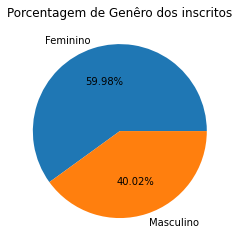

In [31]:
#distribuição do genêro dos inscritos
df_sexo.value_counts().plot(kind='pie', autopct='%.2f%%',ylabel = '',labels = df_sexo['Genêro '],title = 'Porcentagem de Genêro dos inscritos');

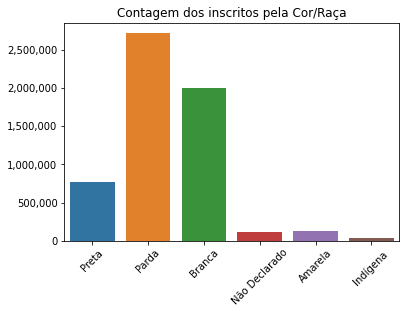

In [32]:
#distribuição dos inscritos pela cor/raça
sns.countplot(df_cor_raca['Cor/Raça'])
plt.xticks(rotation=45);
plt.ylabel("");
plt.xlabel('')
plt.title('Contagem dos inscritos pela Cor/Raça')
y = plt.gca().get_yticks();
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y]);

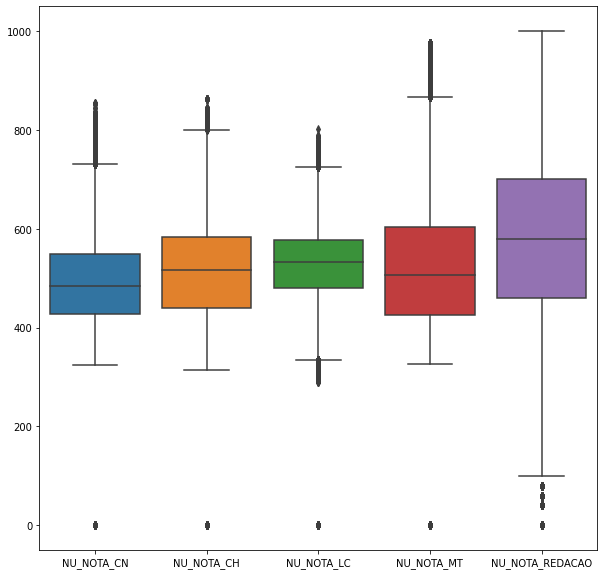

In [33]:
#boxplot das notas do enem
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(data = df_dados_notas, ax = ax);

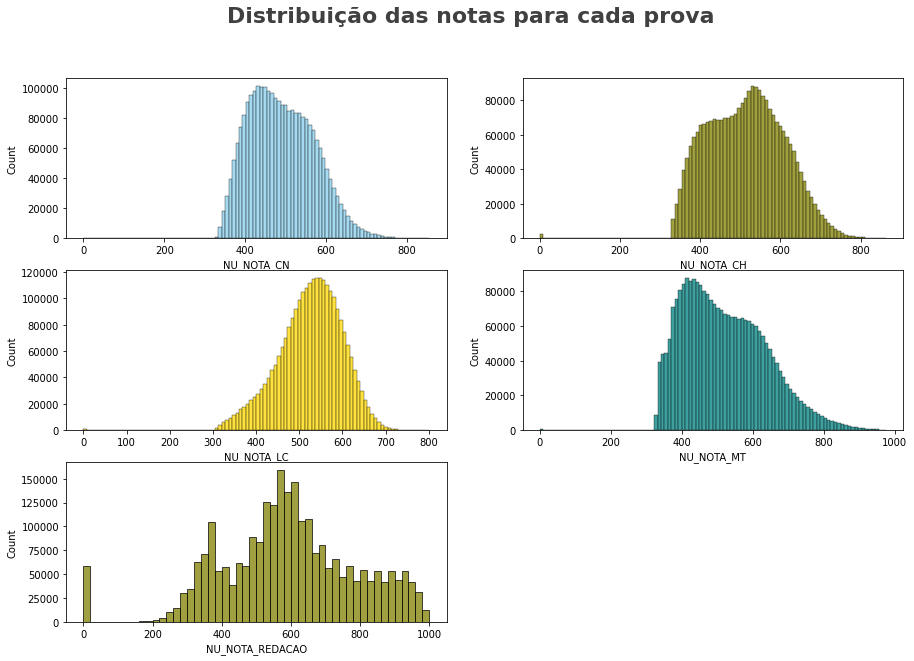

In [34]:
#Distribuicao das notas

# Criando o relátorio
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plotando as notas em histogramas
sns.histplot(data=df_dados_notas, x='NU_NOTA_CN', color='skyblue', bins=100, ax=axs[0, 0])
sns.histplot(data=df_dados_notas, x='NU_NOTA_CH', color='olive', bins=100, ax=axs[0, 1])
sns.histplot(data=df_dados_notas, x='NU_NOTA_LC', color='gold', bins=100, ax=axs[1, 0])
sns.histplot(data=df_dados_notas, x='NU_NOTA_MT', color='teal', bins=100, ax=axs[1, 1])
sns.histplot(data=df_dados_notas, x='NU_NOTA_REDACAO', color='olive', bins=50, ax=axs[2, 0])
axs[2, 1].set_axis_off()

# Incluindo o Titulo na Figura
plt.suptitle('Distribuição das notas para cada prova', fontsize=22, color='#404040', fontweight=600);

In [ ]:
df_dados_notas.describe()

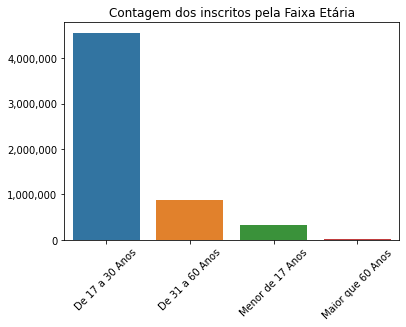

In [36]:
#distribuição dos inscritos pela faixa etária
sns.countplot(df_faixa_etaria['Faixa Etaria'])
plt.xticks(rotation=45);
plt.ylabel("");
plt.xlabel('')
plt.title('Contagem dos inscritos pela Faixa Etária')
y = plt.gca().get_yticks();
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y]);

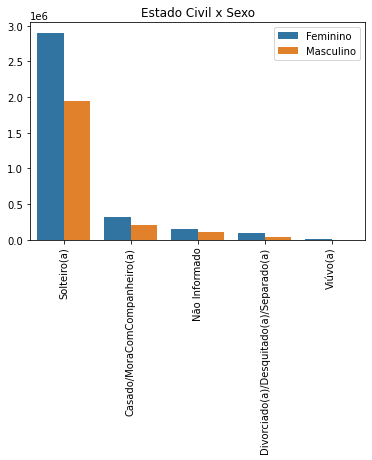

In [37]:
sns.countplot(df_estado_civil['Estado Civil'],hue=df_sexo['Genêro '])
plt.title('Estado Civil x Sexo')
plt.xlabel('')
plt.ylabel("")
plt.xticks(rotation=90);
plt.legend(loc='best')
plt.show()

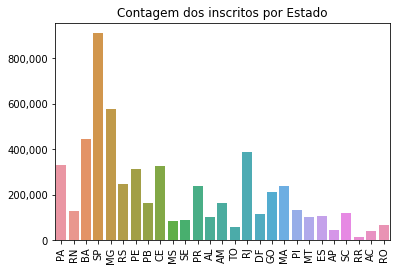

In [38]:
#distribuição dos inscritos peor estado
sns.countplot(df_dados_escola['SG_UF_ESC'])
plt.xticks(rotation=90);
plt.ylabel("");
plt.xlabel('')
plt.title('Contagem dos inscritos por Estado')
y = plt.gca().get_yticks();
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in y]);